# tRNA-Seq simulator

tRNA-Seq generates reads which are annotated through alignment to a pre-defined set of reference sequences.
We assume that if a read is uniquely aligned to one sequence in the reference, then it originated from this tRNA; however, this is a prediction and the true origin a each read is unknown.

In lieu of having reads from known tRNAs we can simulate reads and have them incorporate many of the known characteristics of real tRNA-Seq reads.
The following strategy was used for the tRNA-Seq read simulator:
1. Prepare an idealized tRNA transcript reference set
  * Extract all cytoplasmic tRNA sequences with X nt. length
    * Let X be an input, but most like just use the canonical length of 76 nt.
  * Define a set of possibly modified positions based on where real modifications typically occurs
    * This was done using various publications and MODOMICS and hard-coded as a list inside the simulation object
  * Define a set of 20 modifications with a penetrance i.e. probability of being in the transcript and an underlying probability of an RT event (conditioned on being found in the transcript) from either nothing, mutation (choice between random ATGC, random purine/pyrimidine, random single nt.), gap or RTstop
    * Use integer event codes. Reserve first 7 (1-7) for mutations, then 8 and 9 for gap/RTstop
    * These were defined and store under `/utils/mod_types.json`
  * Apply modifications to reference sequences using an iterative approach, keeping two piles of sequences those with and those without modifications. Iterate through the reference sequences without modifications one at the time:
     * Draw the number of modifications to insert from an appropriate (normal or uniform) distribution and insert them randomly at the predefined positions. Find the hamming distance to all the other reference sequences without modifications and draw those that should receive the same modifications from an appropriate distance to probability distribution (using a family of power functions). Donate the modifications but only to the positions with the same nt. in donor and acceptor. Move all the modified reference sequence(s) to the “modified” pile.
     * Repeat with a new reference sequence from the pile without modifications.
     * When all reference sequences have been modified, stop.
2. Simulate reads in batches e.g. 1e6 sequences
   * Use a matrix representation with one sequence per row, nt. positions in the columns. Fill in a matrix like this with ATGC.
   * Draw ground truth annotations randomly from the reference set
3. Draw baseline (non-modified) RT events from either none, mutation, gap or RTstop
   * For baseline these are exclusionary events i.e. a position can only be: 0=no event, 1=random mismatch, 2=gap or 3=RTstop. Draw this from a (0, 1, 2, 3) array
4. Based on the drawn annotations, create a modification matrix containing the modifications (1-20), then draw the a modification mask to indicate the penetrance of a modification and, conditioned on a modification to be penetrant, find the modification consequence
5. Mask all the baseline events that occurred on a modified position. Then add baseline and modification induced events together.
6. Apply the RT events to the matrix of sampled reference sequences:
   * Do this sequentially, for each RT event
   * Convert to empty string for positions downstream an RT stop 
7. Join matrix rows to strings and remove ‘-’ characters.


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import bz2, copy, os, sys
import logomaker as lm
import numpy as np

# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)

# Import read simulation code:
from src.simulate import TRNA_ReadSim

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/utils/code-of-limited-use
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


In [2]:
### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

In [3]:
# Input files needed for read simulation:
tRNA_ref_fnam = '../../tRNA_database/human/hg38-tRNAs.fa'
tRNA_mod_fnam = '../mod_types.json'
sim_sheet_fnam = 'sim_samples.xlsx'

In [4]:
# Initialize the simulation object
# by making a new reference using default parameters:
sim_obj = TRNA_ReadSim(tRNA_ref_fnam, tRNA_mod_fnam)

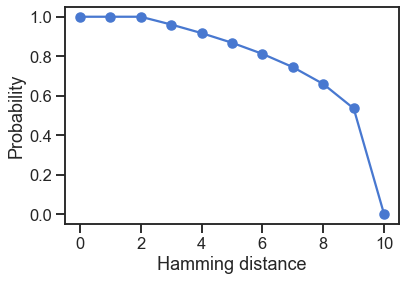

In [5]:
# tRNA modifications are shared between similar
# sequences based on a Bernoulli trial with probability
# based on the hamming distance.
# Plot the distance to probability conversion:
sim_obj.hamming2prob(plot=True)

It is important to realize that the randomly generated reference set is very influential in determining the characteristics of the resulting reads.
This is due to the random choice of modifications and their propagation into other reference sequences due to sharing.
We can see this influence clearly by plotting the coverage and observe the difference in readthrough.

In [6]:
# Function to calculate the coverage:
def seq2cov(reads, ref_len=76):
    cov = np.zeros(ref_len)
    for rds in reads:
        if rds[-2:] == 'CC':
            cov[-(len(rds)+1):] += 1
        else:
            cov[-len(rds):] += 1
    return(cov)

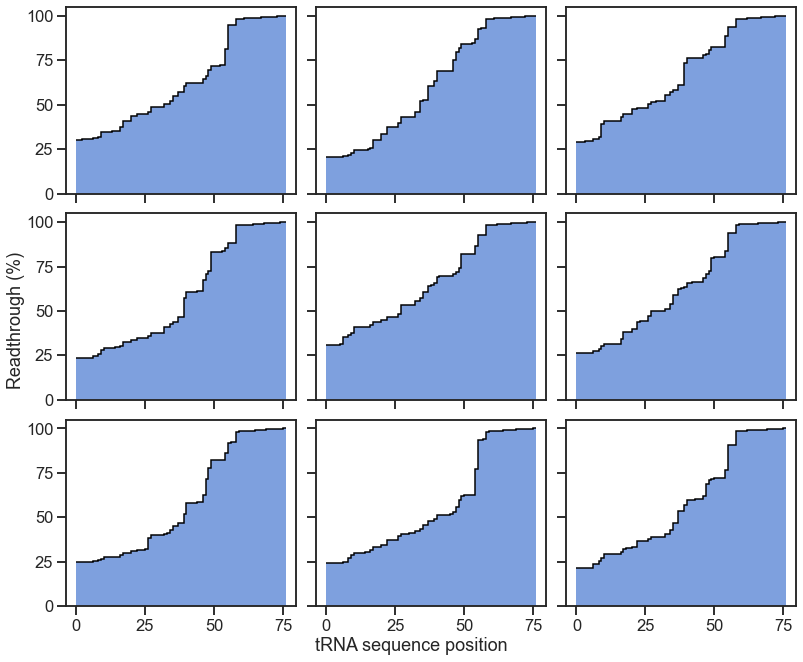

In [7]:
# Plot a 3x3 grid of coverage plots from reads
# drawn from different reference sets:
fig, ax_mat = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(11, 9))
for i in range(3):
    for j in range(3):
        # "Shuffle" the reference set (i.e. re-make it):
        sim_obj.shuffle_reference()
        # Simulate a batch of reads, without stripping internal gaps
        # because these should also contribute to the coverage:
        ann, reads = sim_obj.sim_reads(btch_size=1e4, strip_gaps=False)
        # Calculate and plot coverage:
        cov = seq2cov(reads)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=np.zeros_like(cov), fill=True, \
                            alpha=0.7)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=None, fill=False, \
                            edgecolor='black', alpha=1, linewidth=1.5)

fig.text(0.5, -0.01, 'tRNA sequence position', ha='center', size=18)
fig.text(-0.01, 0.5, 'Readthrough (%)', va='center', rotation='vertical', size=18)
fig.tight_layout()

To control for this difference in reference sets, we can use the `adjust_ref_rdthr` method which will attempt to find a randomly generated reference set that fulfills the requested restrictions.

In [8]:
# Try to find a reference set with readthrough between 40 and 33 %:
sim_obj.adjust_ref_rdthr(rdthr_max=40, rdthr_min=33)

Stopped with reference having 34.56/33.46 max/min coverage accross 5 read batches.


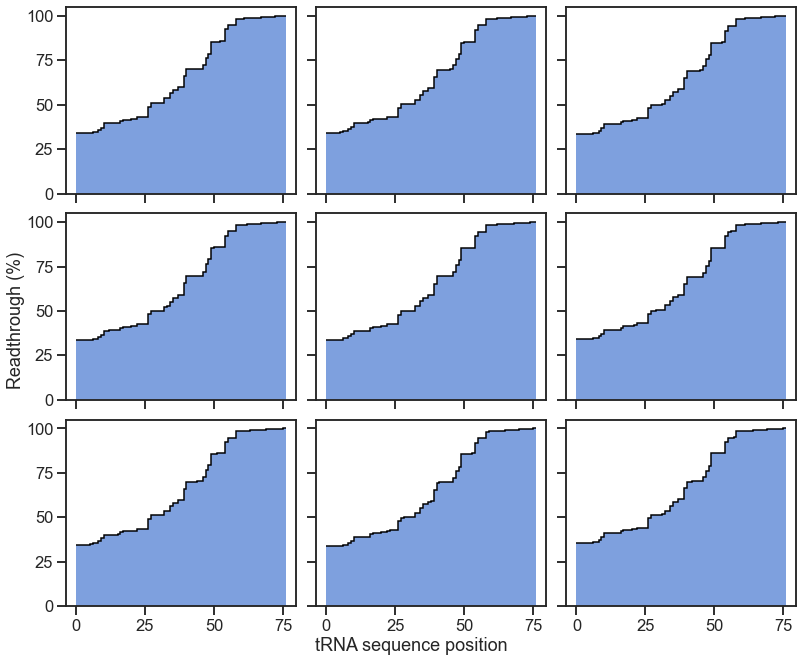

In [9]:
# Plot a 3x3 grid of coverage plots from reads
# drawn from the ~same~ reference set:
fig, ax_mat = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(11, 9))
for i in range(3):
    for j in range(3):
        # Simulate a batch of reads, without stripping internal gaps
        # because these should also contribute to the coverage:
        ann, reads = sim_obj.sim_reads(btch_size=1e4, strip_gaps=False)
        # Calculate and plot coverage:
        cov = seq2cov(reads)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=np.zeros_like(cov), fill=True, \
                            alpha=0.7)
        ax_mat[i, j].stairs(100*cov/len(reads), baseline=None, fill=False, \
                            edgecolor='black', alpha=1, linewidth=1.5)

fig.text(0.5, -0.01, 'tRNA sequence position', ha='center', size=18)
fig.text(-0.01, 0.5, 'Readthrough (%)', va='center', rotation='vertical', size=18)
fig.tight_layout()

With an adjusted reference set we can go ahead a simulate a simulate multiple batches of reads (i.e. samples), specifying the simulation parameters in a sample sheet.
Furthermore, this method will format the reads as fastq format and organize the samples similarly to UMI trimmed reads.

In [10]:
dir_dict, sample_df, tRNA_db_sim = sim_obj.sim_from_sheet(sim_sheet_fnam, NBdir, overwrite_dir=True)

In [11]:
sample_df

,sample_name_unique,sample_name,replicate,barcode_seq,barcode,species,plot_group,hue_name,hue_value,hue_order,N_UMI_observed,N_UMI_expected,percent_UMI_obs-vs-exp
0,100p_1,100p,1,GGCTGCCATGCTGTCACG,l2Sp,human,Charge-titration,Percent charge,100p,1,9900,9905.245375,99.947044
1,100p_2,100p,2,GGCTGCCATGCAAGCTG,l4Sp,human,Charge-titration,Percent charge,100p,1,9900,9905.245375,99.947044
2,75p_1,75p,1,GGCTGCCATGCTACAG,l6Sp,human,Charge-titration,Percent charge,75p,2,9908,9905.245375,100.027810
3,50p_1,50p,1,GGCTGCCATGCAACGTACA,l9Sp,human,Charge-titration,Percent charge,50p,3,9908,9905.245375,100.027810
4,50p_2,50p,2,GGCTGCCATGCTGCGA,l3Sp,human,Charge-titration,Percent charge,50p,3,9903,9905.245375,99.977331
5,25p_1,25p,1,GGCTGCCATGCAACGCATC,l5Sp,human,Charge-titration,Percent charge,25p,4,9903,9905.245375,99.977331
6,0p_1,0p,1,GGCTGCCATGCGACTA,l1Sp,human,Charge-titration,Percent charge,0p,5,9893,9905.245375,99.876375
7,0p_2,0p,2,GGCTGCCATGCACATGA,l7Sp,human,Charge-titration,Percent charge,0p,5,9893,9905.245375,99.876375
